En este notebook se crea una ultima version limpia de los fuegos a partir del documento provaSHP1999.shp

A partir de la seleccion hecha des de QGIS sobre el documento .gdb que nos porporciona Tecnosylva con informaciones diversas sobre todos los incendios sucedidos en california desde 1850, se crea el documento "fuegosPost1999/provaSHP1999.shp" con información  de todos los fuegos entre Enero de 2000 y Diciembre 2019 

Estos datos son limpiados y transformados a WGS para poder posteriormente buscar los puntos mediante coordenadas  long lat. Los guardamos en el documento de 6278 rows × 3 columns (fecha, tamanyo y perimetro):

'fuegos/fuegosFinal/listaFuegosLIMPIA.shp'




In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import datetime
from datetime import date
import timeit

from shapely.geometry import Point,Polygon,MultiPolygon
from shapely.ops import cascaded_union
from pyproj import Proj, transform

import matplotlib.pyplot as plt
#from dateutil.relativedelta import relativedelta

import time

%matplotlib inline

In [2]:

datosFuegos0 = gpd.read_file("fuegosPost1999/provaSHP1999.shp")
datosFuegos0

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Leng,Shape_Area,geometry
0,1.0,2007,CA,CCO,LAC,OCTOBER,00246393,2007/10/21 00:00:00.000,2007/10/23 00:00:00.000,14.0,None,NaN,25.736713,8.0,1.0,00233414,1902.439051,1.041528e+05,"POLYGON ((138036.906 -402646.363, 138086.986 -..."
1,2.0,2007,CA,CCO,LAC,MAGIC,00233077,2007/10/22 00:00:00.000,2007/10/25 00:00:00.000,14.0,None,NaN,2824.877197,8.0,1.0,00233077,20407.965662,1.143187e+07,"POLYGON ((130072.487 -398622.842, 130094.237 -..."
2,3.0,2007,CA,USF,ANF,RANCH,00000166,2007/10/20 00:00:00.000,2007/11/15 00:00:00.000,2.0,None,54716.0,58410.335938,7.0,1.0,00000166,169150.715690,2.363782e+08,"POLYGON ((114013.974 -379231.746, 114190.835 -..."
3,4.0,2007,CA,CCO,LAC,EMMA,00201384,2007/09/11 00:00:00.000,2007/09/11 00:00:00.000,14.0,None,NaN,172.214951,8.0,1.0,00201384,6117.777086,6.969292e+05,"POLYGON ((176902.236 -388673.082, 176907.996 -..."
4,5.0,2007,CA,CCO,LAC,CORRAL,00259483,2007/11/24 00:00:00.000,2007/11/27 00:00:00.000,14.0,None,NaN,4707.997070,8.0,1.0,00259483,22907.182174,1.905259e+07,"POLYGON ((115905.006 -436381.137, 115926.897 -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6331,21435.0,2019,CA,CCO,LAC,MUREAU,None,2019/10/30 00:00:00.000,2019/10/30 00:00:00.000,NaN,None,NaN,6.297734,NaN,1.0,None,741.886109,2.548602e+04,"POLYGON ((122180.088 -428557.696, 122181.545 -..."
6332,21436.0,2019,CA,LRA,None,OAK,None,2019/10/28 00:00:00.000,2019/10/28 00:00:00.000,14.0,NPS#596 Rapid ROS in light grassy 1yr old fuels,NaN,8.482671,8.0,1.0,None,1004.069271,3.432815e+04,"POLYGON ((120221.043 -428836.863, 120220.166 -..."
6333,21437.0,2019,CA,LRA,LDF,BARHAM,00000845,2019/11/09 00:00:00.000,2019/11/10 00:00:00.000,14.0,LACFD 0845,NaN,64.888229,8.0,1.0,None,3383.890106,2.625933e+05,"POLYGON ((153212.742 -428811.823, 153216.210 -..."
6334,21438.0,2019,CA,NPS,MNP,STAR,00013598,None,None,14.0,None,NaN,66.587181,8.0,1.0,None,3897.065019,2.694688e+05,"POLYGON ((409025.711 -295687.235, 409021.609 -..."


# limpiamos los datos.
 para borrar el minimo valores. 
     - reducimos primero el numero de columnas 
     - seguidamente borramos los nan
     - detectamos y corregimos en lo posible valores obiamente anomalos. 

 se puede mejorar suponiendo la fecha de inicio a partir de la fecha de extincion cuando la primera no esta, aunque esto solo sucede en 6 casos

In [3]:
#len(firePost1999[firePost1999.ALARM_DATE.isna()]) #51
firePost1999= datosFuegos0.drop(['YEAR_','OBJECTID', 'STATE', 'AGENCY', 'CONT_DATE','CAUSE', 'UNIT_ID' ,'FIRE_NAME' ,'INC_NUM','COMMENTS', 'C_METHOD', 'OBJECTIVE', 'REPORT_AC','FIRE_NUM', 'Shape_Leng', 'Shape_Area'], axis=1)
firePost1999=firePost1999.dropna()

firePost1999

,ALARM_DATE,GIS_ACRES,geometry
0,2007/10/21 00:00:00.000,25.736713,"POLYGON ((138036.906 -402646.363, 138086.986 -..."
1,2007/10/22 00:00:00.000,2824.877197,"POLYGON ((130072.487 -398622.842, 130094.237 -..."
2,2007/10/20 00:00:00.000,58410.335938,"POLYGON ((114013.974 -379231.746, 114190.835 -..."
3,2007/09/11 00:00:00.000,172.214951,"POLYGON ((176902.236 -388673.082, 176907.996 -..."
4,2007/11/24 00:00:00.000,4707.997070,"POLYGON ((115905.006 -436381.137, 115926.897 -..."
...,...,...,...
6330,2019/10/21 00:00:00.000,42.282562,"POLYGON ((133621.354 -438205.997, 133621.094 -..."
6331,2019/10/30 00:00:00.000,6.297734,"POLYGON ((122180.088 -428557.696, 122181.545 -..."
6332,2019/10/28 00:00:00.000,8.482671,"POLYGON ((120221.043 -428836.863, 120220.166 -..."
6333,2019/11/09 00:00:00.000,64.888229,"POLYGON ((153212.742 -428811.823, 153216.210 -..."


In [4]:
fuegosOrdenadosXt = firePost1999.sort_values(by=['ALARM_DATE'] , ascending=False,ignore_index=True)
fuegosOrdenadosXt

,ALARM_DATE,GIS_ACRES,geometry
0,2106/09/26 00:00:00.000,930.506470,"POLYGON ((-24253.448 -27481.751, -24309.173 -2..."
1,2019/12/19 00:00:00.000,12.634579,"POLYGON ((-10551.228 -27844.203, -10548.820 -2..."
2,2019/11/25 00:00:00.000,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3..."
3,2019/11/25 00:00:00.000,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9..."
4,2019/11/21 00:00:00.000,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22..."
...,...,...,...
6274,2000/01/05 00:00:00.000,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -..."
6275,2000/01/04 00:00:00.000,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670..."
6276,2000/01/01 00:00:00.000,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -..."
6277,0219/05/29 00:00:00.000,2.296940,"POLYGON ((213452.071 -468768.278, 213452.494 -..."


# vemos que hay fechas imposibles las corregimos manualmente

In [5]:

fuegosOrdenadosXt['ALARM_DATE'] = fuegosOrdenadosXt['ALARM_DATE'].replace(['2106/09/26 00:00:00.000'],'2016/09/26 00:00:00.000')
fuegosOrdenadosXt['ALARM_DATE'] = fuegosOrdenadosXt['ALARM_DATE'].replace(['0219/05/29 00:00:00.000'],'2019/05/29 00:00:00.000')
fuegosOrdenadosXt['ALARM_DATE'] = fuegosOrdenadosXt['ALARM_DATE'].replace(['0208/11/13 00:00:00.000'],'2008/11/13 00:00:00.000')

fuegosOrdenadosXt

,ALARM_DATE,GIS_ACRES,geometry
0,2016/09/26 00:00:00.000,930.506470,"POLYGON ((-24253.448 -27481.751, -24309.173 -2..."
1,2019/12/19 00:00:00.000,12.634579,"POLYGON ((-10551.228 -27844.203, -10548.820 -2..."
2,2019/11/25 00:00:00.000,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3..."
3,2019/11/25 00:00:00.000,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9..."
4,2019/11/21 00:00:00.000,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22..."
...,...,...,...
6274,2000/01/05 00:00:00.000,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -..."
6275,2000/01/04 00:00:00.000,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670..."
6276,2000/01/01 00:00:00.000,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -..."
6277,2019/05/29 00:00:00.000,2.296940,"POLYGON ((213452.071 -468768.278, 213452.494 -..."


In [6]:
# modificamos el tipo de fecha para poder buscar mejor
listaDeFechas=[]

for fuego in range(len(fuegosOrdenadosXt)):
    fecha=datetime.date(int(fuegosOrdenadosXt.ALARM_DATE[fuego][0:4]),int(fuegosOrdenadosXt.ALARM_DATE[fuego][5:7]),int(fuegosOrdenadosXt.ALARM_DATE[fuego][8:10]))
    listaDeFechas.append(fecha)
len(listaDeFechas)

6279

In [7]:
fuegosOrdenadosXt['DATE']=fuegosOrdenadosXt['ALARM_DATE']
fuegosOrdenadosXt['ALARM_DATE']=listaDeFechas
fuegosOrdenadosXt

,ALARM_DATE,GIS_ACRES,geometry,DATE
0,2016-09-26,930.506470,"POLYGON ((-24253.448 -27481.751, -24309.173 -2...",2016/09/26 00:00:00.000
1,2019-12-19,12.634579,"POLYGON ((-10551.228 -27844.203, -10548.820 -2...",2019/12/19 00:00:00.000
2,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3...",2019/11/25 00:00:00.000
3,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9...",2019/11/25 00:00:00.000
4,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22...",2019/11/21 00:00:00.000
...,...,...,...,...
6274,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -...",2000/01/05 00:00:00.000
6275,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670...",2000/01/04 00:00:00.000
6276,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -...",2000/01/01 00:00:00.000
6277,2019-05-29,2.296940,"POLYGON ((213452.071 -468768.278, 213452.494 -...",2019/05/29 00:00:00.000


In [8]:
del fuegosOrdenadosXt['DATE']
fuegosOrdenados = fuegosOrdenadosXt.sort_values(by=['ALARM_DATE'] , ascending=True,ignore_index=True)
fuegosOrdenados

,ALARM_DATE,GIS_ACRES,geometry
0,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -..."
1,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670..."
2,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -..."
3,2000-02-25,171.886719,"POLYGON ((154724.105 -392690.642, 154727.775 -..."
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-246428.582 161994.989, -24642..."
...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-12860.145 8874.868, -12865.393 8879..."
6275,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22..."
6276,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9..."
6277,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3..."


# he detectado algun proglema que no entiendo en el fuego de la posicion 4284 y lo borro. DE hecho sale en rojo en lugar de en verde pero tampoco se pq

In [9]:
fuegosOrdenados['GIS_ACRES'][4284]

21.705001831054688

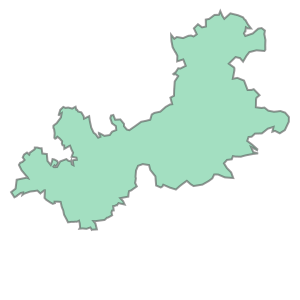

In [10]:
fuegosOrdenados['geometry'][4283]

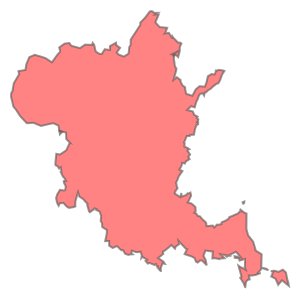

In [11]:
fuegosOrdenados['geometry'][4284]

In [12]:

fuegosOrdenados2= fuegosOrdenados.drop(fuegosOrdenados.index[4284])
fuegosOrdenados2

,ALARM_DATE,GIS_ACRES,geometry
0,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -..."
1,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670..."
2,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -..."
3,2000-02-25,171.886719,"POLYGON ((154724.105 -392690.642, 154727.775 -..."
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-246428.582 161994.989, -24642..."
...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-12860.145 8874.868, -12865.393 8879..."
6275,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22..."
6276,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9..."
6277,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3..."


In [13]:
fuegosOrdenados2.crs

{'proj': 'aea',
 'lat_1': 34,
 'lat_2': 40.5,
 'lat_0': 0,
 'lon_0': -120,
 'x_0': 0,
 'y_0': -4000000,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

# los convertimos a 4326

In [99]:
fuegoS_4326  = fuegosOrdenados2.to_crs({'init': 'epsg:4326'})
fuegoS_4326

,ALARM_DATE,GIS_ACRES,geometry
0,2000-01-01,4.834736,"POLYGON ((-118.73853 36.44793, -118.73883 36.4..."
1,2000-01-04,41.443298,"POLYGON ((-120.11343 38.01911, -120.11400 38.0..."
2,2000-01-05,8.172387,"POLYGON ((-120.52776 34.55901, -120.52774 34.5..."
3,2000-02-25,171.886719,"POLYGON ((-118.31511 34.46959, -118.31507 34.4..."
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-122.86557 39.44029, -122.8654..."
...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-120.14683 38.09611, -120.14689 38.0..."
6275,2019-11-21,73.552673,"POLYGON ((-120.94091 40.04237, -120.94090 40.0..."
6276,2019-11-25,24.590448,"POLYGON ((-121.32173 38.83918, -121.32190 38.8..."
6277,2019-11-25,3125.905518,"MULTIPOLYGON (((-119.79348 34.49110, -119.7935..."


# Recogemos el centroide de los fuegos

In [100]:
fuegosLimpios=fuegoS_4326.copy()
fuegosLimpios['geometry'] = fuegoS_4326.centroid

fuegosLimpios['lon'] = fuegosLimpios['geometry'].x
fuegosLimpios['lat'] = fuegosLimpios['geometry'].y

fuegosLimpios

,ALARM_DATE,GIS_ACRES,geometry,lon,lat
0,2000-01-01,4.834736,POINT (-118.73802 36.44887),-118.738021,36.448869
1,2000-01-04,41.443298,POINT (-120.11081 38.02113),-120.110812,38.021129
2,2000-01-05,8.172387,POINT (-120.52844 34.55805),-120.528435,34.558050
3,2000-02-25,171.886719,POINT (-118.31069 34.46540),-118.310690,34.465403
4,2000-03-25,1358.237549,POINT (-122.85136 39.45528),-122.851361,39.455277
...,...,...,...,...,...
6274,2019-11-19,7.903546,POINT (-120.14810 38.09618),-120.148101,38.096183
6275,2019-11-21,73.552673,POINT (-120.93609 40.04477),-120.936086,40.044771
6276,2019-11-25,24.590448,POINT (-121.32211 38.84152),-121.322107,38.841523
6277,2019-11-25,3125.905518,POINT (-119.76583 34.48706),-119.765827,34.487063


In [101]:
fuegoS_4326['long']=fuegosLimpios['lon']
fuegoS_4326['lat']=fuegosLimpios['lat']
fuegoS_4326

,ALARM_DATE,GIS_ACRES,geometry,long,lat
0,2000-01-01,4.834736,"POLYGON ((-118.73853 36.44793, -118.73883 36.4...",-118.738021,36.448869
1,2000-01-04,41.443298,"POLYGON ((-120.11343 38.01911, -120.11400 38.0...",-120.110812,38.021129
2,2000-01-05,8.172387,"POLYGON ((-120.52776 34.55901, -120.52774 34.5...",-120.528435,34.558050
3,2000-02-25,171.886719,"POLYGON ((-118.31511 34.46959, -118.31507 34.4...",-118.310690,34.465403
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-122.86557 39.44029, -122.8654...",-122.851361,39.455277
...,...,...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-120.14683 38.09611, -120.14689 38.0...",-120.148101,38.096183
6275,2019-11-21,73.552673,"POLYGON ((-120.94091 40.04237, -120.94090 40.0...",-120.936086,40.044771
6276,2019-11-25,24.590448,"POLYGON ((-121.32173 38.83918, -121.32190 38.8...",-121.322107,38.841523
6277,2019-11-25,3125.905518,"MULTIPOLYGON (((-119.79348 34.49110, -119.7935...",-119.765827,34.487063


In [102]:
fuegosLimpios

,ALARM_DATE,GIS_ACRES,geometry,lon,lat
0,2000-01-01,4.834736,POINT (-118.73802 36.44887),-118.738021,36.448869
1,2000-01-04,41.443298,POINT (-120.11081 38.02113),-120.110812,38.021129
2,2000-01-05,8.172387,POINT (-120.52844 34.55805),-120.528435,34.558050
3,2000-02-25,171.886719,POINT (-118.31069 34.46540),-118.310690,34.465403
4,2000-03-25,1358.237549,POINT (-122.85136 39.45528),-122.851361,39.455277
...,...,...,...,...,...
6274,2019-11-19,7.903546,POINT (-120.14810 38.09618),-120.148101,38.096183
6275,2019-11-21,73.552673,POINT (-120.93609 40.04477),-120.936086,40.044771
6276,2019-11-25,24.590448,POINT (-121.32211 38.84152),-121.322107,38.841523
6277,2019-11-25,3125.905518,POINT (-119.76583 34.48706),-119.765827,34.487063


In [ ]:
fuegoS_4326

In [106]:

fuegoS_4326['ALARM_DATE']=fuegoS_4326['ALARM_DATE'].astype('str')
fuegoS_4326

,ALARM_DATE,GIS_ACRES,geometry,long,lat
0,2000-01-01,4.834736,"POLYGON ((-118.73853 36.44793, -118.73883 36.4...",-118.738021,36.448869
1,2000-01-04,41.443298,"POLYGON ((-120.11343 38.01911, -120.11400 38.0...",-120.110812,38.021129
2,2000-01-05,8.172387,"POLYGON ((-120.52776 34.55901, -120.52774 34.5...",-120.528435,34.558050
3,2000-02-25,171.886719,"POLYGON ((-118.31511 34.46959, -118.31507 34.4...",-118.310690,34.465403
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-122.86557 39.44029, -122.8654...",-122.851361,39.455277
...,...,...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-120.14683 38.09611, -120.14689 38.0...",-120.148101,38.096183
6275,2019-11-21,73.552673,"POLYGON ((-120.94091 40.04237, -120.94090 40.0...",-120.936086,40.044771
6276,2019-11-25,24.590448,"POLYGON ((-121.32173 38.83918, -121.32190 38.8...",-121.322107,38.841523
6277,2019-11-25,3125.905518,"MULTIPOLYGON (((-119.79348 34.49110, -119.7935...",-119.765827,34.487063


# GUARDAMOS LA LSITA DE FUEGOS DEFININTIVA COMO listaFuegosLIMPIA.shp

In [107]:
#GUARDADOS
#para poderlo guardar en shapefile primero tenemos que convertir la fecha en string

direccion='fuegosFinal/listaFuegosLIMPIA.shp' #to shapefile
fuegoS_4326.to_file(direccion)

In [108]:
#una vez guardado comprobamos que funciona correctamente
direccion='fuegosFinal/listaFuegosLIMPIA.shp'
dfTstr= gpd.read_file(direccion)

#para recuperar los el dataframe fuegoS_4326 con las fechas comparables
# convertir los str en fechas
dfTstr["ALARM_DATE"]= pd.to_datetime(dfTstr["ALARM_DATE"])

dfTstr

,ALARM_DATE,GIS_ACRES,long,lat,geometry
0,2000-01-01,4.834736,-118.738021,36.448869,"POLYGON ((-118.73853 36.44793, -118.73883 36.4..."
1,2000-01-04,41.443298,-120.110812,38.021129,"POLYGON ((-120.11343 38.01911, -120.11400 38.0..."
2,2000-01-05,8.172387,-120.528435,34.558050,"POLYGON ((-120.52776 34.55901, -120.52774 34.5..."
3,2000-02-25,171.886719,-118.310690,34.465403,"POLYGON ((-118.31511 34.46959, -118.31507 34.4..."
4,2000-03-25,1358.237549,-122.851361,39.455277,"MULTIPOLYGON (((-122.86557 39.44029, -122.8654..."
...,...,...,...,...,...
6273,2019-11-19,7.903546,-120.148101,38.096183,"POLYGON ((-120.14683 38.09611, -120.14689 38.0..."
6274,2019-11-21,73.552673,-120.936086,40.044771,"POLYGON ((-120.94091 40.04237, -120.94090 40.0..."
6275,2019-11-25,24.590448,-121.322107,38.841523,"POLYGON ((-121.32173 38.83918, -121.32190 38.8..."
6276,2019-11-25,3125.905518,-119.765827,34.487063,"MULTIPOLYGON (((-119.79348 34.49110, -119.7935..."
